In [269]:
import pandas as pd
import numpy as np
import pymc as pm
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 500)

In [179]:
def split_data(data, tackles):
    for name in tackles:
        tackle = data[data['tackle_name'] == name]
        train_x = pd.DataFrame()
        test_x = pd.DataFrame()
        train_y = pd.DataFrame()
        test_y = pd.DataFrame()
        if len(tackle) > 25:
            tackle_x = tackle.drop(['one_sec_dist'], axis = 1)
            tackle_y = tackle[tackle['one_sec_dist']]
            x_train,x_test,y_train,y_test=train_test_split(tackle_x,tackle_y,test_size=0.2, random_state = 1029)
            train_x = pd.concat([train_x, x_train])
            test_x = pd.concat([test_x, x_test])
            train_y = pd.concat([train_y, y_train])
            test_y = pd.concat([test_y, y_test])
    return train_x, test_x, train_y, test_y

## Speed
Our response will be predicted get off time
    - Need to decide how we want to do this
    - Option 1 is amount of time to get to a certain distance (Say 1.5 yards)
    - Option 2 would be predicted yards given a cetain amount of time
For predictors:
    - Height/weight of the tackle
    - Quarter
    - Whether it's an obvious passing situation
    - Left vs right tackle?

## Power
Our response here is some variation of percentage of the distance to the QB given up once engaged with the defensive end
For predictors:
    - Height/weight of both the tackle and the end
    - Obvious passing situation
    - Time to throw for the QB
    - Quarter

In [101]:
model_data = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/clustered.csv')

In [102]:
model_data.columns

Index(['uniqueplayId', 'QB_Flip', 'rushType', 'Power_prob', 'Speed_prob',
       'football_x', 'football_y', 'gameId', 'playId', 'frameId', 'time',
       'playDirection', 'event', 'ball_snap_frame', 'end_frame',
       'play_length_frames', 'Right_end', 'Left_end', 'QB_nflId',
       'QB_jerseyNumber', 'QB_team', 'QB_x', 'QB_y', 'QB_s', 'QB_a', 'QB_dis',
       'QB_o', 'QB_dir', 'QB_pff_role', 'QB_pff_positionLinedUp',
       'QB_pff_nflIdBlockedPlayer', 'QB_pff_blockType', 'QB_new_x', 'QB_new_y',
       'ball_nflId', 'ball_jerseyNumber', 'ball_team', 'ball_x', 'ball_y',
       'ball_s', 'ball_a', 'ball_dis', 'ball_o', 'ball_dir', 'ball_pff_role',
       'ball_pff_positionLinedUp', 'ball_pff_nflIdBlockedPlayer',
       'ball_pff_blockType', 'ball_new_x', 'ball_new_y', 'ball_Flip',
       'Tackle_nflId', 'Tackle_jerseyNumber', 'Tackle_team', 'Tackle_x',
       'Tackle_y', 'Tackle_s', 'Tackle_a', 'Tackle_dis', 'Tackle_o',
       'Tackle_dir', 'Tackle_pff_role', 'Tackle_pff_positionLined

In [103]:
model_data2 = model_data[['uniqueplayId','QB_Flip','rushType','Power_prob','Speed_prob',
            'football_x', 'football_y', 'gameId', 'playId', 'frameId', 'time',
       'event','play_length_frames','QB_s', 'QB_a', 'QB_dis',
       'QB_o', 'QB_dir', 'QB_pff_role', 'QB_pff_positionLinedUp','QB_new_x', 'QB_new_y',
            'ball_new_x', 'ball_new_y', 'ball_Flip','ball_snap_frame',
       'Tackle_nflId', 'Tackle_s', 'Tackle_a', 'Tackle_dis', 'Tackle_o',
       'Tackle_dir', 'Tackle_pff_role', 'Tackle_pff_positionLinedUp',
       'Tackle_pff_nflIdBlockedPlayer', 'Tackle_pff_blockType', 'Tackle_new_x',
       'Tackle_new_y', 'Tackle_Flip', 'End_nflId', 'End_s', 'End_a', 'End_dis', 'End_o',
       'End_dir', 'End_pff_role', 'End_pff_positionLinedUp', 'End_new_x',
       'End_new_y', 'End_Flip', 'tackle_end_dist', 'tackle_end_facing']]

In [104]:
players = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/players.csv')

In [105]:
players = players[['height', 'weight', 'nflId','displayName']]

In [106]:
model_data3 = model_data2.merge(players, left_on = 'Tackle_nflId', right_on = 'nflId', how = 'left')

In [107]:
model_data4 = model_data3.rename(columns = {'height':'tackle_height','weight':'tackle_weight','displayName':'tackle_name'}).drop('nflId', axis = 1)

In [108]:
model_data5 = model_data4.merge(players, left_on = 'End_nflId', right_on = 'nflId', how = 'left')

In [109]:
model_data6 = model_data5.rename(columns = {'height':'end_height','weight':'end_weight','displayName':'end_name'}).drop('nflId', axis = 1)

In [110]:
plays = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/plays.csv')

In [111]:
plays['obvious_pass'] = ((plays['down'] == 2) & (plays['yardsToGo'] > 10)) | ((plays['down'] == 3) & (plays['yardsToGo'] > 4)) | ((plays['down'] == 4) & (plays['yardsToGo'] > 2))

In [112]:
plays['obvious_pass'] = plays['obvious_pass'].astype(int)

In [113]:
plays = plays[['gameId','playId','quarter','obvious_pass']]

In [114]:
plays

,gameId,playId,quarter,obvious_pass
0,2021090900,97,1,0
1,2021090900,137,1,0
2,2021090900,187,1,0
3,2021090900,282,1,0
4,2021090900,349,1,1
...,...,...,...,...
8553,2021110100,4310,4,1
8554,2021110100,4363,4,0
8555,2021110100,4392,4,0
8556,2021110100,4411,4,1


In [115]:
model_data7 = model_data6.merge(plays, on = ['gameId','playId'], how = 'left')

In [116]:
model_data7['tackle_end_engaged'] = (model_data7['tackle_end_facing'] <= 40) & (model_data7['tackle_end_dist'] <= 1)

In [117]:
model_data7['tackle_end_engaged'] = model_data7['tackle_end_engaged'].astype(int)

In [118]:
model_data7['tackle_end_engaged'].value_counts()

0    224075
1     61595
Name: tackle_end_engaged, dtype: int64

In [119]:
def dist(x_1, y_1, x_2, y_2):
    return np.sqrt(np.sum([(x_1-x_2)**2, (y_1-y_2)**2], axis=0))

In [120]:
model_data7['tackle_qb_dist'] = dist(model_data7['Tackle_new_x'], model_data7['Tackle_new_y'], model_data7['QB_new_x'], model_data7['QB_new_y'])

In [121]:
model_data7['end_qb_dist'] = dist(model_data7['End_new_x'], model_data7['End_new_y'], model_data7['QB_new_x'], model_data7['QB_new_y'])

In [122]:
speed = model_data7[model_data7['rushType'] == 'Speed']
speed

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,tackle_weight,tackle_name,end_height,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist
0,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,6,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.554492,6.473832
1,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,7,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.610878,6.481790
2,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,8,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.651021,6.451364
3,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,9,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.667987,6.361549
4,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,10,...,322,Tristan Wirfs,6-3,245,Micah Parsons,1,0,0,4.714106,6.192205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285594,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,27,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,4.893107,6.758913
285595,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,28,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,4.787839,6.807437
285596,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,29,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,4.674409,6.866513
285597,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,30,...,305,Charles Leno,6-0,232,Nick Bolton,2,0,0,4.555052,6.941823


In [123]:
power = model_data7[model_data7['rushType'] == 'Power']

In [124]:
subset = power[power['tackle_end_engaged'] == 1]

In [125]:
subset2 = subset.groupby(['uniqueplayId','QB_Flip']).first().reset_index()

In [126]:
distance_when_engaged = subset2[['uniqueplayId','QB_Flip','tackle_qb_dist']]
distance_when_engaged

,uniqueplayId,QB_Flip,tackle_qb_dist
0,202109120163,0.0,3.927467
1,202109120163,1.0,5.853136
2,202109120676,0.0,4.894865
3,202109120676,1.0,3.900820
4,202109120776,0.0,4.369760
...,...,...,...
5394,20211025003660,1.0,5.355978
5395,20211025003904,0.0,3.735305
5396,20211025003904,1.0,4.439279
5397,20211025003926,0.0,4.778002


In [127]:
end_distance = model_data7.groupby(['uniqueplayId','QB_Flip']).last().reset_index()

In [128]:
end_distance = end_distance[['uniqueplayId','QB_Flip','tackle_qb_dist']]
end_distance

,uniqueplayId,QB_Flip,tackle_qb_dist
0,202109090097,1.0,4.178002
1,202109120163,0.0,2.438237
2,202109120163,1.0,2.884996
3,202109120288,0.0,4.254656
4,202109120288,1.0,6.659084
...,...,...,...
8773,20211025003684,1.0,1.628558
8774,20211025003904,0.0,1.994242
8775,20211025003904,1.0,4.460717
8776,20211025003926,0.0,8.396076


In [129]:
end_distance = end_distance.rename(columns = {'tackle_qb_dist': 'ending_distance'})

In [130]:
distance = distance_when_engaged.merge(end_distance, on = ['uniqueplayId', 'QB_Flip'], how = 'left')
distance

,uniqueplayId,QB_Flip,tackle_qb_dist,ending_distance
0,202109120163,0.0,3.927467,2.438237
1,202109120163,1.0,5.853136,2.884996
2,202109120676,0.0,4.894865,4.135372
3,202109120676,1.0,3.900820,1.730665
4,202109120776,0.0,4.369760,3.628361
...,...,...,...,...
5394,20211025003660,1.0,5.355978,3.138057
5395,20211025003904,0.0,3.735305,1.994242
5396,20211025003904,1.0,4.439279,4.460717
5397,20211025003926,0.0,4.778002,8.396076


In [131]:
distance['pct_given_up'] = (distance['tackle_qb_dist'] - distance['ending_distance']) / distance['tackle_qb_dist']
distance

,uniqueplayId,QB_Flip,tackle_qb_dist,ending_distance,pct_given_up
0,202109120163,0.0,3.927467,2.438237,0.379183
1,202109120163,1.0,5.853136,2.884996,0.507103
2,202109120676,0.0,4.894865,4.135372,0.155161
3,202109120676,1.0,3.900820,1.730665,0.556333
4,202109120776,0.0,4.369760,3.628361,0.169666
...,...,...,...,...,...
5394,20211025003660,1.0,5.355978,3.138057,0.414102
5395,20211025003904,0.0,3.735305,1.994242,0.466110
5396,20211025003904,1.0,4.439279,4.460717,-0.004829
5397,20211025003926,0.0,4.778002,8.396076,-0.757236


In [132]:
distance = distance.rename(columns = {'tackle_qb_dist' : 'starting_distance'})

In [133]:
model_data8 = model_data7.merge(distance, on = ['uniqueplayId','QB_Flip'], how = 'left')
model_data8

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,starting_distance,ending_distance,pct_given_up
0,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,6,...,245,Micah Parsons,1,0,0,4.554492,6.473832,NaN,NaN,NaN
1,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,7,...,245,Micah Parsons,1,0,0,4.610878,6.481790,NaN,NaN,NaN
2,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,8,...,245,Micah Parsons,1,0,0,4.651021,6.451364,NaN,NaN,NaN
3,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,9,...,245,Micah Parsons,1,0,0,4.667987,6.361549,NaN,NaN,NaN
4,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,10,...,245,Micah Parsons,1,0,0,4.714106,6.192205,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285665,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,25,...,315,Jordan Elliott,3,0,0,5.114626,6.142353,NaN,NaN,NaN
285666,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,26,...,315,Jordan Elliott,3,0,0,5.084191,6.162735,NaN,NaN,NaN
285667,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,27,...,315,Jordan Elliott,3,0,0,5.049287,6.169935,NaN,NaN,NaN
285668,20211021002175,1.0,Power,NaN,NaN,92.41,29.85,2021102100,2175,28,...,315,Jordan Elliott,3,0,0,5.002799,6.168249,NaN,NaN,NaN


In [134]:
## Going to need to remove any power plays where this is an NA
model_data8 = model_data8.dropna(subset = ['pct_given_up'])

In [135]:
speed['dist_moved'] = speed.groupby(['uniqueplayId','QB_Flip'])['Tackle_dis'].cumsum()

<ipython-input-135-e5681bf5ed00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed['dist_moved'] = speed.groupby(['uniqueplayId','QB_Flip'])['Tackle_dis'].cumsum()


In [136]:
one_yard = speed[speed['dist_moved'] >= 1].groupby(['uniqueplayId','QB_Flip']).first().reset_index()

In [137]:
one_yard = one_yard[['uniqueplayId','QB_Flip','frameId','ball_snap_frame']]

In [138]:
one_yard['tackle_get_off_time'] = (one_yard['frameId'] - one_yard['ball_snap_frame'])*.1

In [139]:
get_off = one_yard[['uniqueplayId','QB_Flip','tackle_get_off_time']]

In [140]:
speed2 = speed.merge(get_off, on = ['uniqueplayId','QB_Flip'], how = 'left')

In [141]:
speed2

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_height,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,dist_moved,tackle_get_off_time
0,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,6,...,6-3,245,Micah Parsons,1,0,0,4.554492,6.473832,0.03,0.8
1,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,7,...,6-3,245,Micah Parsons,1,0,0,4.610878,6.481790,0.09,0.8
2,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,8,...,6-3,245,Micah Parsons,1,0,0,4.651021,6.451364,0.19,0.8
3,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,9,...,6-3,245,Micah Parsons,1,0,0,4.667987,6.361549,0.34,0.8
4,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,10,...,6-3,245,Micah Parsons,1,0,0,4.714106,6.192205,0.48,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92817,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,27,...,6-0,232,Nick Bolton,2,0,0,4.893107,6.758913,4.82,0.7
92818,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,28,...,6-0,232,Nick Bolton,2,0,0,4.787839,6.807437,5.11,0.7
92819,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,29,...,6-0,232,Nick Bolton,2,0,0,4.674409,6.866513,5.39,0.7
92820,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,30,...,6-0,232,Nick Bolton,2,0,0,4.555052,6.941823,5.66,0.7


In [142]:
## Now looking at yards traveled in the first second
one_sec = speed2[speed2['frameId'] == speed2['ball_snap_frame'] + 10]
one_sec = one_sec[['uniqueplayId','QB_Flip','dist_moved']].rename(columns = {'dist_moved':'one_sec_dist'})

In [143]:
speed3 = speed2.merge(one_sec, on = ['uniqueplayId','QB_Flip'], how = 'left')

In [144]:
speed3

,uniqueplayId,QB_Flip,rushType,Power_prob,Speed_prob,football_x,football_y,gameId,playId,frameId,...,end_weight,end_name,quarter,obvious_pass,tackle_end_engaged,tackle_qb_dist,end_qb_dist,dist_moved,tackle_get_off_time,one_sec_dist
0,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,6,...,245,Micah Parsons,1,0,0,4.554492,6.473832,0.03,0.8,1.46
1,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,7,...,245,Micah Parsons,1,0,0,4.610878,6.481790,0.09,0.8,1.46
2,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,8,...,245,Micah Parsons,1,0,0,4.651021,6.451364,0.19,0.8,1.46
3,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,9,...,245,Micah Parsons,1,0,0,4.667987,6.361549,0.34,0.8,1.46
4,202109090097,1.0,Speed,0.08467,0.91533,41.56,23.92,2021090900,97,10,...,245,Micah Parsons,1,0,0,4.714106,6.192205,0.48,0.8,1.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92959,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,27,...,232,Nick Bolton,2,0,0,4.893107,6.758913,4.82,0.7,1.93
92960,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,28,...,232,Nick Bolton,2,0,0,4.787839,6.807437,5.11,0.7,1.93
92961,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,29,...,232,Nick Bolton,2,0,0,4.674409,6.866513,5.39,0.7,1.93
92962,20211017071173,0.0,Speed,NaN,NaN,57.90,24.08,2021101707,1173,30,...,232,Nick Bolton,2,0,0,4.555052,6.941823,5.66,0.7,1.93


In [145]:
one_sec_dist_df = speed3.groupby(['uniqueplayId', 'QB_Flip']).apply(lambda x: x['one_sec_dist'].unique()[0]).reset_index().rename(columns={0:'one_sec_dist'})

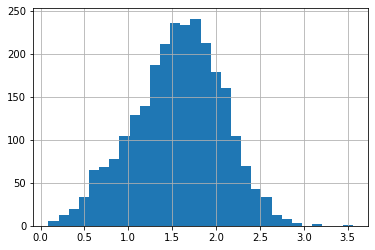

In [146]:
one_sec_dist_df['one_sec_dist'].hist(bins=30);

In [147]:
speed3.groupby(['uniqueplayId', 'QB_Flip']).apply(lambda x: x['end_name'].unique()[0]).reset_index().rename(columns={0:'end_name'})['end_name'].value_counts()[0:50]

Harold Landry          75
Chase Young            40
Myles Garrett          39
Shaquil Barrett        36
Brian Burns            34
Khalil Mack            33
Trey Hendrickson       33
Jason Pierre-Paul      32
Derek Barnett          32
Haason Reddick         31
Yannick Ngakoue        30
Von Miller             29
Joey Bosa              27
T.J. Watt              27
Malik Reed             26
Leonard Floyd          26
Montez Sweat           25
Everson Griffen        24
Cameron Jordan         24
Alex Highsmith         24
Al-Quadin Muhammad     24
Matt Judon             23
Rashan Gary            23
Darrell Taylor         23
Maxx Crosby            22
Josh Allen             22
Chandler Jones         22
Terrell Lewis          22
Danielle Hunter        22
Odafe Oweh             21
Robert Quinn           21
Nick Bosa              21
Olasunkanmi Adeniyi    20
Dante Fowler           20
Preston Smith          20
Aaron Donald           20
Josh Sweat             19
Bryce Huff             19
Charles Harr

In [148]:
speed3[speed3['end_name'] == 'Harold Landry']['uniqueplayId'].value_counts()

2021091912943     67
20210919124574    54
20210912071703    53
20211010043129    50
20211024052903    47
                  ..
2021101004538     21
2021102405360     21
20211018001449    21
20211010043914    21
20211024052732    20
Name: uniqueplayId, Length: 75, dtype: int64

In [149]:
play = pd.read_csv('https://media.githubusercontent.com/media/cnickol26/BigDataBowl2023/main/nfl-big-data-bowl-2023/plays.csv')

In [150]:
play['uniqueplayId'] = play['gameId'].astype(str) + play['playId'].astype(str)

In [151]:
play[play['uniqueplayId'].isin(['2021102405360','20211018002346','20210912071703','20211010043914','20211010043129'])]

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,uniqueplayId
656,2021091207,1703,(6:50) (Shotgun) K.Murray pass incomplete deep...,2,1,10,ARI,TEN,ARI,25,...,35.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,20210912071703
4885,2021101004,3129,(12:21) (Shotgun) T.Lawrence pass deep left to...,4,1,10,JAX,TEN,JAX,30,...,80.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,1,Cover-2,Zone,20211010043129
4899,2021101004,3914,"(:31) (No Huddle, Shotgun) T.Lawrence pass sho...",4,3,1,JAX,TEN,JAX,48,...,62.0,EMPTY,"1 RB, 1 TE, 3 WR",4.0,"3 DL, 2 LB, 6 DB",TRADITIONAL,0,Cover-3,Zone,20211010043914
6574,2021101800,2346,"(12:41) (No Huddle, Shotgun) J.Allen pass shor...",3,1,10,BUF,TEN,BUF,44,...,66.0,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"2 DL, 4 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,20211018002346
7061,2021102405,360,(10:21) (Shotgun) P.Mahomes pass short right t...,1,2,5,KC,TEN,KC,30,...,80.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,2021102405360


In [152]:
power_speed_perc = model_data7.groupby(['end_name', 'uniqueplayId', 'QB_Flip']).agg({
    'rushType':'first'
}).reset_index().groupby('end_name')['rushType'].agg(
    power_perc = lambda x: x[x == 'Power'].count()/x.count(),
    speed_perc = lambda x: x[x == 'Speed'].count()/x.count(),
    total = 'count'
).reset_index()

In [153]:
overall_perc_avs = model_data7.groupby(['uniqueplayId', 'QB_Flip']).agg({
    'rushType':'first'
}).reset_index()['rushType'].value_counts(normalize=True)
overall_perc_avs

Power    0.704147
Speed    0.295853
Name: rushType, dtype: float64

In [154]:
power_speed_perc['Av_Power'] = overall_perc_avs[0]
power_speed_perc['Av_Speed'] = overall_perc_avs[1]
power_speed_perc['num_plays'] = power_speed_perc['total'].sum()
power_speed_perc['end_power_perc'] = power_speed_perc['power_perc']*(power_speed_perc['total']/500) + power_speed_perc['Av_Power']*(1-power_speed_perc['total']/500)
power_speed_perc['end_speed_perc'] = power_speed_perc['speed_perc']*(power_speed_perc['total']/500) + power_speed_perc['Av_Speed']*(1-power_speed_perc['total']/500)

In [155]:
speed3 = speed3.merge(power_speed_perc[['end_name', 'end_power_perc', 'end_speed_perc']], how='left', on='end_name')

In [156]:
# Aggregate for grouped by to prepare data for modeling - one row per tackle/end instance
# The row should have the distance of the tackle in one second, and multiple predictors
# The predictors are speed/power percent of the end, weight and height of end, one-hot offensive linesman, obvious passing situation, and maybe quarter
def full_agg(grouped_df):
    row = grouped_df[grouped_df['frameId']==grouped_df['ball_snap_frame']+10]
    return pd.DataFrame({
    'one_sec_dist': row['dist_moved'],
    'end_power_perc': row['end_power_perc'],
    'end_speed_perc':  row['end_speed_perc'],
    'end_height': row['end_height'],
    'end_weight': row['end_weight'],
    'tackle_name': row['tackle_name'],
    'obvious_pass': row['obvious_pass'],
    'quarter': row['quarter']
})

speed_data = speed3.groupby(['uniqueplayId', 'QB_Flip'], group_keys=True).apply(full_agg).reset_index().drop(['level_2'], axis=1)
speed_data

,uniqueplayId,QB_Flip,one_sec_dist,end_power_perc,end_speed_perc,end_height,end_weight,tackle_name,obvious_pass,quarter
0,202109090097,1.0,1.46,0.698632,0.301368,6-3,245,Tristan Wirfs,0,1
1,202109120288,0.0,1.36,0.697389,0.302611,6-3,275,Mekhi Becton,0,1
2,202109120578,0.0,0.76,0.704525,0.295475,6-5,262,Laremy Tunsil,0,1
3,202109120776,1.0,1.44,0.705116,0.294884,6-5,265,David Quessenberry,1,1
4,202109121176,1.0,1.79,0.713767,0.286233,6-5,277,Ryan Ramczyk,0,1
...,...,...,...,...,...,...,...,...,...,...
2598,20211025003484,0.0,2.05,0.708573,0.291427,5-11,310,Terron Armstead,0,4
2599,20211025003506,0.0,0.87,0.711732,0.288268,6-4,279,Terron Armstead,1,4
2600,20211025003536,1.0,1.98,0.703389,0.296611,6-4,330,Ryan Ramczyk,0,4
2601,20211025003660,0.0,1.95,0.699022,0.300978,6-4,260,Terron Armstead,1,4


In [157]:
speed_data['end_height'] = [int(j)*12+int(i) for j, i in speed_data['end_height'].str.split('-')]

In [158]:
speed_data

,uniqueplayId,QB_Flip,one_sec_dist,end_power_perc,end_speed_perc,end_height,end_weight,tackle_name,obvious_pass,quarter
0,202109090097,1.0,1.46,0.698632,0.301368,75,245,Tristan Wirfs,0,1
1,202109120288,0.0,1.36,0.697389,0.302611,75,275,Mekhi Becton,0,1
2,202109120578,0.0,0.76,0.704525,0.295475,77,262,Laremy Tunsil,0,1
3,202109120776,1.0,1.44,0.705116,0.294884,77,265,David Quessenberry,1,1
4,202109121176,1.0,1.79,0.713767,0.286233,77,277,Ryan Ramczyk,0,1
...,...,...,...,...,...,...,...,...,...,...
2598,20211025003484,0.0,2.05,0.708573,0.291427,71,310,Terron Armstead,0,4
2599,20211025003506,0.0,0.87,0.711732,0.288268,76,279,Terron Armstead,1,4
2600,20211025003536,1.0,1.98,0.703389,0.296611,76,330,Ryan Ramczyk,0,4
2601,20211025003660,0.0,1.95,0.699022,0.300978,76,260,Terron Armstead,1,4


In [234]:
tackles = speed_data['tackle_name'].unique()
len(tackles)

112

In [281]:
## Do we want to leave the tackles in the train set who don't have enough snaps to get test data? A couple need to be removed for sure since they are tight ends so I set keep if we have 5 instances
def split_data(data, tackles):
    train_x = pd.DataFrame()
    test_x = pd.DataFrame()
    for name in tackles:
        tackle = data[data['tackle_name'] == name]
        if len(tackle) > 4:
            if len(tackle) >= 25:
                tackle_x = tackle.drop(['one_sec_dist'], axis = 1)
                x_train,x_test = train_test_split(tackle, test_size=0.2, random_state = 1029)
                train_x = pd.concat([train_x, x_train])
                test_x = pd.concat([test_x, x_test])
            else:
                train_x = pd.concat([train_x, tackle])
    return train_x, test_x

In [282]:
train_x, test_x = split_data(speed_data, tackles)

In [287]:
train_x['tackle_name'].value_counts()

Orlando Brown           52
Donovan Smith           47
George Fant             42
Cameron Erving          42
Dion Dawkins            40
David Quessenberry      40
Alejandro Villanueva    38
Kaleb McGary            36
Penei Sewell            36
Tristan Wirfs           36
D.J. Humphries          36
Garett Bolles           35
Matt Nelson             35
Jason Peters            34
Dan Moore               34
Rashod Hill             33
Bobby Massie            32
Jake Matthews           32
Nate Solder             32
Cam Robinson            31
Kolton Miller           30
Morgan Moses            30
Liam Eichenberg         30
Taylor Moton            29
Patrick Mekari          28
Billy Turner            28
Tyron Smith             27
Rob Havenstein          26
Mike McGlinchey         26
Duane Brown             26
Storm Norton            25
Taylor Lewan            25
Jordan Mailata          25
Germain Ifedi           24
Justin Herron           24
Charles Leno            24
Samuel Cosmi            24
R

In [283]:
test_x['tackle_name'].value_counts()

Orlando Brown           14
Donovan Smith           12
Cameron Erving          11
George Fant             11
D.J. Humphries          10
David Quessenberry      10
Alejandro Villanueva    10
Dion Dawkins            10
Kaleb McGary            10
Tristan Wirfs            9
Rashod Hill              9
Dan Moore                9
Jason Peters             9
Matt Nelson              9
Penei Sewell             9
Garett Bolles            9
Jake Matthews            9
Nate Solder              9
Cam Robinson             8
Patrick Mekari           8
Billy Turner             8
Bobby Massie             8
Kolton Miller            8
Taylor Moton             8
Morgan Moses             8
Liam Eichenberg          8
Taylor Lewan             7
Justin Herron            7
Charles Leno             7
Brian O'Neill            7
Duane Brown              7
Tyron Smith              7
Storm Norton             7
Jordan Mailata           7
Rob Havenstein           7
Mike McGlinchey          7
Riley Reiff              6
A

In [284]:
## Amount removed as is
len(speed_data) - len(train_x) - len(test_x)

30

In [285]:
len(test_x) + len(train_x)

2573